Competition: https://www.kaggle.com/c/digit-recognizer/overview

## Data loading and inspection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('train_digit_recognizer.csv')
print(df.shape)
df.head(3)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print('Total count of NAN-values:', df.isnull().sum().sum())

Total count of NAN-values: 0


In [5]:
df_train = df.iloc[:30001, :]
df_test = df.iloc[30001:, :]

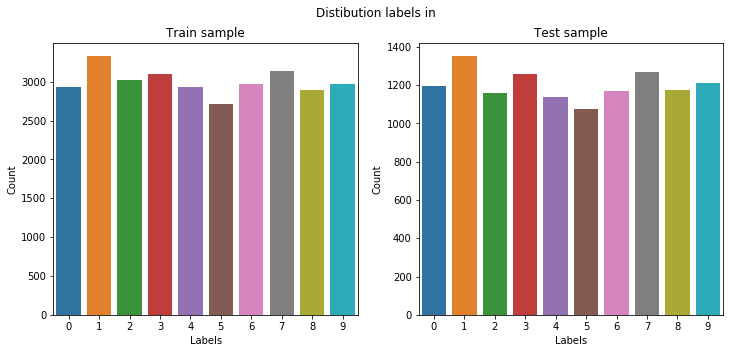

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
sns.barplot(y = df_train.label.value_counts().values, x = df_train.label.value_counts().index, ax = ax[0])
ax[0].set_title('Train sample')
ax[0].set_xlabel('Labels')
ax[0].set_ylabel('Count')


sns.barplot(y = df_test.label.value_counts().values, x = df_test.label.value_counts().index, ax = ax[1])
ax[1].set_title('Test sample')
ax[1].set_xlabel('Labels')
ax[1].set_ylabel('Count')


fig.suptitle('Distibution labels in ')
plt.show()

## Preparing data for CNN

In [27]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [65]:
class dataforCNN(Dataset):
    def __init__(self, df):
        self.X = df.iloc[:, 1:].values
        self.y = df.iloc[:, 0].values
        self.n = self.X.shape[0]
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        # there is only one canal (we must normilize it)
        X_index = torch.FloatTensor(self.X[index])/255
        X_index = X_index.view(1, 28, 28)
        y_index = self.y[index]
        return (X_index, y_index)

In [102]:
trainloader = DataLoader(dataforCNN(df_train), batch_size = 4, shuffle = True)
testloader = DataLoader(dataforCNN(df_test), batch_size = 4, shuffle = True)

In [103]:
# define cnn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train model

In [120]:
def train_model(num_epoch):
    running_loss = []
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            
            outputs = net.forward(inputs)
            loss_here = func_loss(outputs, labels)
            
            opt.zero_grad()
            loss_here.backward()
            opt.step()
            
            epoch_loss += loss_here.item()
            
            if i % 750 == 749:
                running_loss.append(epoch_loss)
                epoch_loss = 0
    return running_loss        

57.52054238377241


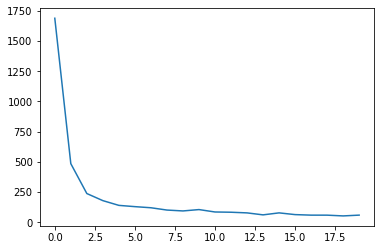

In [125]:
# with momentum but lr is lower
net = Net()
func_loss = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr=0.001, momentum = 0.95)
mas_loss = train_model(2)

print(mas_loss[-1])
plt.plot(mas_loss)
plt.show()

53.876774847590696


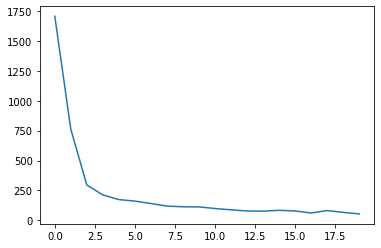

In [126]:
# without momentum but lr is higher
net = Net()
func_loss = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr=0.01)

mas_loss = train_model(2)
print(mas_loss[-1])
plt.plot(mas_loss)
plt.show()

## Upload to kaggle

In [127]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        X_samp, labels = data
        outputs = net(X_samp)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on train images: ', correct/total)

Accuracy of the network on train images:  0.9728310692557713


In [128]:
test_df = pd.read_csv('test_digit_recognazer.csv')

In [129]:
test_tensor = torch.tensor(test_df.values, dtype=torch.float) / 255
test_tensor = test_tensor.view(-1, 1, 28, 28)

In [130]:
out = net(test_tensor)

In [131]:
_, pred = torch.max(out, 1)

In [133]:
sub = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': pred.numpy()})
sub.to_csv('first_cnn.csv', index=False)